# BitTiger DS501 Week10

1. [Feedforward Neural Network](#Feedforward-Neural-Network)
2. LSTM
   * [Text generation](#Text-generation)
   * [Twiter](#Twiter)
3. [CNN](#CNN)
4. Tensorflow
   * [Devise](#Devise)
   * [Linear regression](#Linear-regression)
   * [Tensorboard](#Tensorboard)
5. Homework
   * [Ref](#Reference)
   * [Solution](#Solution)

## Feedforward Neural Network

* **FFNN**

In [1]:
from __future__ import print_function # Must be the first line

import keras.callbacks as cb
from keras.datasets import mnist
from keras.layers.core import Activation, Dense, Dropout
from keras.models import Sequential
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.utils import np_utils

import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## 1. Pre-processing

### 分成 3 個 Groups:
1. A: 沒有 pre-processing
2. B: 用 normalization 把 dataset normalize 到 [0, 1] 之間
\begin{equation}x' = \frac{x - x_{min}}{x_{max} - x_{min}}\end{equation}
3. C: 用 standardization 把 dataset 變成 mean=0, variance=1 的高斯分佈
\begin{equation}x_i' = \frac{x_i - \mu}{\sigma}\end{equation}

通常知道數據的最大值和最小值的時候，就使用 normalization，如果不知道最大值和最小值，就使用 standardization

In [2]:
def Preprocessing(group):
    from sklearn import preprocessing
    # Load MNIST dataset from Keras (https://keras.io/datasets/)
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Transform labels to one-hot
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    
    # Set features to numeric type
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    # Reshape from 28 x 28 to 1-D vector
    # 28 x 28 = 784
    X_train = np.reshape(X_train, (60000, 784))
    X_test = np.reshape(X_test, (10000, 784))
    
    if group == 'A':
        return X_train, X_test, y_train, y_test
    elif group == 'B':
        X_train /= 255
        X_test /= 255
    elif group == 'C':
        X_train = preprocessing.scale(X_train)
        X_test = preprocessing.scale(X_test)
        
    return X_train, X_test, y_train, y_test

In [3]:
group = 'B'
X_train, X_test, y_train, y_test = Preprocessing(group)

### 檢查一下 training data

只看前 10 筆資料

In [4]:
print('{:^44}'.format('X'), '|', '{:^4}'.format('y'))
print('='*50)
for row in range(10):
    print('{:.2f} {:.2f} ... {:.2f} {:.2f} {:.2f}  ... {:.2f} {:.2f} '.format(
            X_train[row][0], X_train[row][1],
            X_train[row][156], X_train[row][157], X_train[row][158],
            X_train[row][-2], X_train[row][-1]), '| ',
            '{:.0f}'.format(y_train[row][0])
         )

                     X                       |  y  
0.00 0.00 ... 0.49 0.53 0.69  ... 0.00 0.00  |  0
0.00 0.00 ... 0.99 0.99 0.99  ... 0.00 0.00  |  1
0.00 0.00 ... 0.00 0.00 0.00  ... 0.00 0.00  |  0
0.00 0.00 ... 0.00 0.00 0.49  ... 0.00 0.00  |  0
0.00 0.00 ... 0.00 0.00 0.00  ... 0.00 0.00  |  0
0.00 0.00 ... 0.10 0.39 0.48  ... 0.00 0.00  |  0
0.00 0.00 ... 0.00 0.00 0.00  ... 0.00 0.00  |  0
0.00 0.00 ... 0.99 0.99 0.99  ... 0.00 0.00  |  0
0.00 0.00 ... 0.00 0.00 0.00  ... 0.00 0.00  |  0
0.00 0.00 ... 0.00 0.00 0.00  ... 0.00 0.00  |  0


## 2. Define model

### Network Structure

經驗上：寬度 < 1000 個 neurons，深度 10 ~ 30 層，形狀用金字塔型

深度可以用 sample/parameter raton 來估計，約 5 ~ 30
* 通常 10 ~ 30 層
* 目前最深 150 層


1. A: 1 layer
2. B: 2 layers, tower-shaped (一樣寬)
3. C: 2 layers, pyramid-shaped (越來越窄)

In [5]:
def layers(group):
    if group == 'A':
        first_layer_width = 128
        second_layer_width = 0
    elif group == 'B':
        first_layer_width = 128
        second_layer_width = 128
    elif group == 'C':
        first_layer_width = 128
        second_layer_width = 64
        
    return first_layer_width, second_layer_width

### Activation Function
1. ReLU
2. Sigmoid
3. Tanh

![activation_function](https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-08-at-11-53-41-am.png)

Sigmoid($x$) 和 $\tanh(x)$ 在 $x$ 很大或很小時 (就是在兩端時)，會有 **vanishing gradient** 的問題

ReLU($x$) 在 $x > 0$ 時不會有 vanishing gradient 的問題 

In [6]:
# activation_func = 'relu'
# activation_func = 'sigmoid'
# activation_func = 'tanh'

In [7]:
def activation_function(func):
    if func == 'relu':
        return 'relu'
    elif func == 'sigmoid':
        return 'sigmoid'
    elif func == 'tanh':
        return 'tanh'
    else:
        return func

### Loss Function

Loss function 又叫做 cost function，就是 prediction 和 ground truth 之間的差別。

算 loss 時要算的是 total loss $L = \sum_{i=1}^{R} \ell_i$，然後要把 total loss minimize

常用的 loss function 有兩種:
1. Cross entropy: 適合 categorical 的數據
   \begin{equation} -\sum_{i=1}^{k} (y_{i} \log\hat{y}_{i})\end{equation}
2. Squared error (MSE): 適合 continuous 的數據
   \begin{equation}\sum_{i=1}^{k}(y_{i} - \hat{y}_{i})^{2}\end{equation}

In [8]:
def loss_func(loss):
    if loss == 'crossentropy':
        return 'categorical_crossentropy'
    elif loss == 'MSE':
        return 'mean_squared_error'

### Dropout rate
可以輸入想要的 dropout rate，例如 0%, 50%, 90% 等

* dropout rate < 0.5
  * 通常是 0.1 ~ 0.3
* 每一層都有一個 dropout rate，在 training 前就要定義好，因為 dropout rate 是 hyperparameter
* Training 才要 dropout，**testing 不 dropout**
  * Training 每一層關掉 p% 的神經元
  * Testing 的 weight $\times (1-p\%)$

In [9]:
def set_dropout_rate(num):
    if num > 1:
        print('Dropout rate is between 0 and 1')
        return
    else:
        return num

### Regularization

目標是 minimize $\Big(\sum_{i=1}^{R} L(y_i, \hat{y}_i) + R(w) \Big)$

1. No regularization: no
2. L1-norm: l1
   \begin{equation}R(w, \lambda) = \lambda ||w||_{1} = \lambda \sum_{i}|w|_{i} = \lambda(|w_1| + |w_2| + \cdots + |w_k|)\end{equation}
3. L2-norm: l2
   \begin{equation}R(w, \lambda) = \lambda ||w||_{2} = \lambda \sqrt{\sum_{i} w_{i}^{2}} = \lambda \sqrt{w_1^2 + w_2^2 + \cdots + w_k^2}\end{equation}
   
還有一個是 max-norm，這是一個 post-processing 的過程，不會在 optimization 時發生。每一個 weight 更新之後，就再除以自己的 norm，再乘上 $\lambda$ 使得新的 weight 一定小於 $\lambda$，這樣子 weight 就不會爆掉。
* $||w||_2 < \lambda$，$\lambda$ 的值大概是 $3 \sim 4$

In [10]:
def regularization(regularization = None):
    if regularization == 'l1':
        return 'l1'
    elif regularization == 'l2':
        return 'l2'
    else:
        return regularization

### Mini-batch size
可以設定 mini-batch 的大小，例如 128, 256, 512 等

通常是 4 的倍數，這和硬體 cache 的設計有關 

In [11]:
def mini_batch_size(size):
    if size == 128:
        return 128
    elif size == 256:
        return 256
    elif size == 512:
        return 512
    else:
        return size

### Learning Rate

可以設定 learning rate 的大小，例如 0.1, 0.01, 0.5 等

\begin{equation}w' \leftarrow w - \eta \cdot \frac{\partial L}{\partial w}\end{equation}

learning rate $\eta$ 決定大小，$\frac{\partial L}{\partial w}$ 決定方向

通常介於 0.01 到 0.1 之間

同一個 epoch 的 learning rate 是常數，epoch 越多時，learning rate 就越會調越小。
* $\eta_i = \eta_{i-1}/\sqrt{i+1}$
* AdaGrad: \begin{equation}\eta_w = \frac{\eta}{\sqrt{\sum_{i=0}^{t}g_i^2}}, g_i = \frac{\partial L}{\partial w}\end{equation}

In [12]:
def set_learning_rate(rate):
    if rate == 0.1:
        return 0.1
    elif rate == 0.01:
        return 0.01
    elif rate == 0.5:
        return 0.5
    else:
        return rate

### 這邊才是定義 model

In [13]:
def DefineModel():
    # Initialize
    model = Sequential()
    
    # Initialize all variables
    first_layer_width, second_layer_width = layers('C')
    activation_func = activation_function('relu')
    loss_function = loss_func('crossentropy')
    dropout_rate = set_dropout_rate(0.0)
    weight_regularizer = regularization()
    learning_rate = set_learning_rate(0.1)
    
    # Add first hidden layer
    model.add(Dense(first_layer_width, input_dim=784, W_regularizer=weight_regularizer))
    model.add(Activation(activation_func))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
        
    # Add second hidden layer
    if second_layer_width > 0:
        model.add(Dense(second_layer_width))
        model.add(Activation(activation_func))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
            
    # Last layer has the same dimension as the number of classes
    model.add(Dense(10))
    # Then add softmax
    model.add(Activation('softmax'))
    # Define optimizer
    opt = SGD(lr=learning_rate, clipnorm=5.)
    # Define loss function
    model.compile(loss=loss_function, optimizer=opt, metrics=['accuracy'])
    
    return model

### 定義怎麼 train model

In [14]:
def TrainModel(data=None, epochs=20):
    batch = mini_batch_size(128)
    start_time = time.time()
    model = DefineModel()
    
    if data is None:
        print('Must provide data.')
        return
    
    X_train, X_test, y_train, y_test = data
    print('Start training...')
    
    # There are 60,000 samples
    # Use the first 50,000 to train and last 10,000 to validate.
    history = model.fit(X_train[:55000], y_train[:55000], 
                        nb_epoch=epochs, batch_size=batch,
                        validation_data=(X_train[55000:], y_train[55000:]))
    print('Training took {0} seconds.'.format(time.time() - start_time))
    return model, history

### 定義怎麼 test model

In [15]:
def TestModel(model=None, data=None):
    if model is None:
        print('Must provide a trained model.')
        return
    if data is None:
        print('Must provide data.')
        return
    x_test, y_test = data
    scores = model.evaluate(x_test, y_test)
    return scores

### 開始訓練

In [16]:
trained_model, training_history = TrainModel(data=[X_train, X_test, y_train, y_test])

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, input_dim=784, kernel_regularizer=None)`
  
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Start training...
Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 56us/step - loss: 0.4678 - acc: 0.8677 - val_loss: 0.2032 - val_acc: 0.9402
Epoch 2/20
55000/55000 [==============================] - 2s 39us/step - loss: 0.2220 - acc: 0.9352 - val_loss: 0.1432 - val_acc: 0.9608
Epoch 3/20
55000/55000 [==============================] - 2s 41us/step - loss: 0.1652 - acc: 0.9517 - val_loss: 0.1165 - val_acc: 0.9672
Epoch 4/20
55000/55000 [==============================] - 2s 37us/step - loss: 0.1337 - acc: 0.9614 - val_loss: 0.1060 - val_acc: 0.9710
Epoch 5/20
55000/55000 [==============================] - 2s 42us/step - loss: 0.1122 - acc: 0.9673 - val_loss: 0.0954 - val_acc: 0.9738
Epoch 6/20
55000/55000 [==============================] - 3s 49us/step - loss: 0.0969 - acc: 0.9715 - val_loss: 0.0977 - val_acc: 0.9724
Epoch 7/20
55000/55000 [==============================] - 2s 45us/step - loss: 0.0851 - acc: 0.9752 - val_loss:

### 畫圖看結果

#### Loss 和 Accuracy

In [17]:
def PlotHistory(train_value, test_value, value_is_loss_or_acc):
    fig, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc=0)
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)

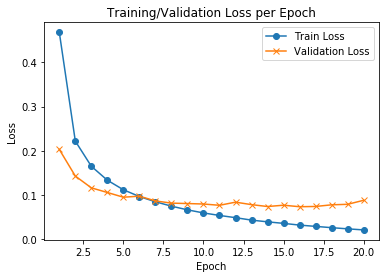

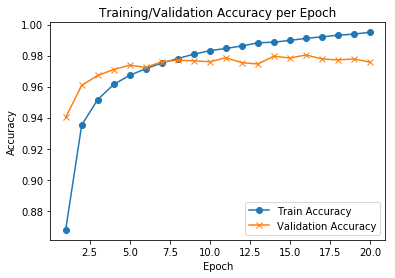

In [18]:
PlotHistory(training_history.history['loss'], training_history.history['val_loss'], 'Loss')
PlotHistory(training_history.history['acc'], training_history.history['val_acc'], 'Accuracy')

#### Regularization

In [19]:
def drawWeightHistogram(x):
    fig, ax = plt.subplots()
    n, bins, patches = plt.hist(x, 50)
    plt.xlim(-0.5, 0.5)
    plt.xlabel('Weight')
    plt.ylabel('Count')
    zero_counts = (x == 0.0).sum()
    plt.title("Weight Histogram. Num of '0's: %d" % zero_counts)

In [20]:
wl = trained_model.layers[0].get_weights()[0].flatten()
drawWeightHistogram(wl)

### 看 model 跑 test sample 的分數

In [21]:
test_score = TestModel(model=trained_model, data=[X_test, y_test])
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

10000/10000 [==============================] - 0s 29us/step
Test loss 0.0855, accuracy 97.62%


### 一些畫圖的函數

In [22]:
def ShowInputImage(data):
    '''Visualize input image.'''
    plot = plt.figure()
    plot.set_size_inches(2, 2)
    plt.imshow(np.reshape(-data, (28, 28)), cmap='Greys_r')
    plt.title('Input')
    plt.axis('off')
    plt.show()

In [23]:
def ShowHiddenLayerOutput(input_data, target_layer_num):
    '''Visualize output from the target hidden layer.'''
    from keras import backend as K
    # backend converter: to TensorFlow
    target_layer = K.function(trained_model.inputs, [trained_model.layers[target_layer_num].output])
    # Extract output from the target hidden layer
    target_layer_out = target_layer([input_data])
    plot = plt.figure()
    plot.set_size_inches(2, 2)
    plt.imshow(np.reshape(-target_layer_out[0][0], (16, -1)), cmap='Greys_r')
    plt.title('Hidden layer ' + str(target_layer_num))
    plt.axis('off')
    plt.show()

In [24]:
def ShowFinalOutput(input_data):
    '''Calculate final prediction.'''
    from keras import backend as K
    # backend converter: to TensorFlow
    # Calculate final prediction
    last_layer = K.function(trained_model.inputs, [trained_model.layers[-1].output])
    last_layer_out = last_layer([input_data])
    print('Final prediction: ' + str(np.argmax(last_layer_out[0][0])))

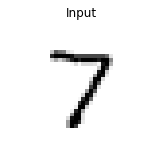

Final prediction: 7


In [25]:
ShowInputImage(X_test[0])
ShowHiddenLayerOutput(X_test, 1)
ShowFinalOutput(X_test)

In [26]:
import tensorflow as tf
print(tf.__version__)

1.12.0


***
***
***

## LSTM

### Text generation

* 用尼采的文章來產生像是尼采寫的文章
  * 如果是要用其他的輸入，那 corpus 至少要 ~100k，但最好是 ~1M
* 至少要 20 個 epochs 才能訓練出比較像樣的文章
* 需要用 GPU 加速

In [1]:
from __future__ import print_function # must occur at the beginning of the file

import numpy as np
import random
import sys

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from keras.optimizers import SGD
from keras.utils.data_utils import get_file

Using TensorFlow backend.


* `read(size)`: size is an optional numeric argument and this func returns a quantity of data equal to size. If size if omitted, then it reads the entire file and returns it
* `readline()`: reads a single line from file with newline at the end
* `readlines()`: returns a list containing all the lines in the file
* `xreadlines()`: Returns a generator to loop over every single line in the file

In [3]:
path = get_file('nietzsche.txt', origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")

corpus = None
with open(path) as f:
    corpus = f.read() # read entire file
    corpus = corpus.lower() # change all characters to lower case

# 也可以用一行解決
# corpus = open(path).read().lower()
    
print('corpus length=', len(corpus))

corpus length= 600893


corpus 是一個字串，儲存了整篇文章的內容

In [4]:
print(type(corpus))
print(corpus[:100]) # 顯示前 100 個字元

<class 'str'>
preface


supposing that truth is a woman--what then? is there not ground
for suspecting that all ph


找出所有獨立的字元 (不是找單字)

In [5]:
chars = sorted(list(set(corpus)))

print(chars)
print('total chars=', len(chars))

['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ä', 'æ', 'é', 'ë']
total chars= 57


把 index 和 char 的 mapping 做成 dictionary

In [6]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

In [7]:
maxlen = 40
step = 3
sentences = []
next_chars = []

for i in range(0, len(corpus) - maxlen, step):
    sentences.append(corpus[i:i + maxlen])
    next_chars.append(corpus[i + maxlen]) # 因為要由前面的內容來預測下一個字元，所以要先把下一個字元找出來
print('Number of sentences=', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
        y[i, char_indices[next_chars[i]]] = 1

Number of sentences= 200285
Vectorization...


### Build LSTM model

In [8]:
# 只建立一個 LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(64, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = SGD(lr=1)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [9]:
def sample(preds, temperature=1.0):
    '''
    Helper function to sample an index for a probability array
    '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

訓練模型，每個 iteration 結束就把產生的字輸出

In [10]:
for iteration in range(1, 20):
    print()
    print('-'*50)
    print('Iteration', iteration)
    model.fit(X, y, batch_size=128, epochs=1)
    
    start_index = np.random.randint(0, len(corpus) - maxlen - 1)
    
#     for diversity in [0.2, 0.5, 1.0, 1.2]:
    for diversity in [0.5]:
        print()
        print('----- diversity = ', diversity)
        
        generated = ''
        sentence = corpus[start_index : start_index + maxlen]
        generated += sentence
        print('Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)
        
        for i in range(200):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1. # 注意是小寫的 x
                
            preds = model.predict(x, verbose=0)[0] # 注意是小寫的 x
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]
            
            generated += next_char
            sentence = sentence[1:] + next_char
            
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()


--------------------------------------------------
Iteration 1
Epoch 1/1
200285/200285 [==============================] - 204s 1ms/step - loss: 2.5089

----- diversity =  0.5
Generating with seed: "he temptation to this wickedness is none"
he temptation to this wickedness is none as the fithens her and and the morsed and the and for and calle anter wal bee as the made all stalust hom hant the pavester he hare and of the and anter the and in the as the instuing.
a the forine b

--------------------------------------------------
Iteration 2
Epoch 1/1
200285/200285 [==============================] - 208s 1ms/step - loss: 2.0998

----- diversity =  0.5
Generating with seed: "sity--delusions are smuggled in. even lo"
sity--delusions are smuggled in. even loense it es in the plosting oul one whe ereate far an his inderions and sucice an is and of the sallige, and mans, as the phaseres be and man of chilation and the love are fores in the berear, exalien,

-----------------------------------

***
***
***

## LSTM

## Twiter

In [1]:
from __future__ import print_function

import csv
import numpy as np
import operator
import re

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
max_vocabulary = 10000
maxlen = 20
batch_size = 256

In [3]:
def preprocess_words(words):
    # Remove consecutive period symbols
    words = re.sub(r"[\. ][\. ]+", " . ", words)
    # Replace word+comma with word [space] comma
    words = re.sub(r",", " , ", words)
    # Replace word+parenthesis with word [space] parenthesis.
    # E.g., this(is) -> this ( is )
    words = re.sub(r"[\(\)]", " \l ", words)
    return words.split()

In [4]:
def load_twitter(filename):
    labels = []
    tweets = []
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            # Column names = ItemID, Sentiment, SentimentSource, SentimentText
            labels.append(int(row['Sentiment']))
            words = row['SentimentText'].strip().lower()
            tweets.append(preprocess_words(words))
    return np.array(tweets), np.array(labels)

In [5]:
print('Loading data...')
tweets, labels = load_twitter('/Users/ytshen/Desktop/BitTiger_DS501/Week_10/AWS/Sentiment_Analysis_Dataset.csv')
print('Load', len(labels), 'tweets')
print('First tweet: {}'.format(' '.join(tweets[0])))
print('First tweet label: {}'.format(labels[0]))

Loading data...
Load 1578614 tweets
First tweet: is so sad for my apl friend .
First tweet label: 0


In [6]:
# randomize tweets and create training/test sets
np.random.seed(1337)
rand_idx = np.random.permutation(len(labels))
rand_idx[:-10000]

array([1452430,  436092,  950568, ...,  144292, 1033477, 1548193])

In [7]:
# select last 10000 tweets as test set
tweets_training = tweets[rand_idx[:-10000]]
labels_training = labels[rand_idx[:-10000]]

tweets_test = tweets[rand_idx[-10000:]]
labels_test = labels[rand_idx[-10000:]]

In [8]:
def build_vocabulary(tweets):
    print('### Example tweets:')
    print(' '.join(tweets[0]))
    print(' '.join(tweets[1]))
    vocab = dict()
    for t in tweets:
        for word in t:
            if word.startswith('@'): # ignore twitter username
                continue
            if word not in vocab:
                vocab[word] = 0
            vocab[word] += 1
    # sort vocabulary by count
    vocab = sorted(vocab.items(), key=operator.itemgetter(1), reverse=True)
    # keep only top max_vocabulary ones
    vocab = vocab[:max_vocabulary - 1] # max_vocabulary - 1: reserve one spot for 'unknown' token.
    vocab.append(('<unk>', 0))
    print('### Top 5 vocabs after sorting:')
    print(vocab[:5])
    return vocab

In [9]:
vocabulary = build_vocabulary(tweets_training)

### Example tweets:
i want food , more more food !
@sims2 i didn't . i'll download it tonight !
### Top 5 vocabs after sorting:
[('.', 2517683), ('!', 906643), ('i', 757581), ('to', 557162), ('the', 515735)]


In [10]:
def save_vocab(vocabulary):
    with open('vocab.txt', 'w') as vf:
        for v in vocabulary:
            vf.write(v[0])
            vf.write('\t')
            vf.write(str(v[1]))
            vf.write('\n')

In [11]:
save_vocab(vocabulary)

In [12]:
def create_vocab_index(vocab):
    vocab_idx = dict()
    v_id = 0
    for v in vocab:
        vocab_idx[v[0]] = v_id
        v_id += 1
    return vocab_idx

In [13]:
vocab_word_to_id = create_vocab_index(vocabulary)
vocab_id_to_word = [(idx, word) for (word, idx) in vocab_word_to_id.items()]

In [14]:
def transcode_words(sents, vocab_index):
    coded_words = [[vocab_index[w] if w in vocab_index else vocab_index['<unk>'] for w in words] for words in sents]
    return coded_words

In [15]:
tweets_training_to_id = transcode_words(tweets_training, vocab_word_to_id)
tweets_test_to_id = transcode_words(tweets_test, vocab_word_to_id)

In [16]:
# must transcode from word to word_id first!!
print('Pad sequences (samples x time)')
tweets_training_to_id_padded = sequence.pad_sequences(tweets_training_to_id, maxlen=maxlen)
tweets_test_to_id_padded = sequence.pad_sequences(tweets_test_to_id, maxlen=maxlen)
print('features shape:', tweets_training_to_id_padded.shape)

Pad sequences (samples x time)
features shape: (1568614, 20)


In [17]:
# turn label to one-hot
labels_training_onehot = to_categorical(labels_training, num_classes=2)
labels_test_onehot = to_categorical(labels_test, num_classes=2)

In [18]:
def build_model():
    print('Building model...')
    model = Sequential()
    model.add(Embedding(max_vocabulary, 300))
    model.add(LSTM(16, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation='sigmoid'))
    
    # try using different optimizers and different optimizer configs
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [19]:
def train(model):
    print('Train...')
    model.fit(tweets_training_to_id_padded, labels_training_onehot,
              batch_size=batch_size,
              epochs=10,
              validation_data=(tweets_test_to_id_padded, labels_test_onehot))
    score, acc = model.evaluate(tweets_test_to_id_padded, labels_test_onehot, batch_size=batch_size)
    print('Test score:', score)
    print('Test accuracy:', acc)

In [20]:
tweet_classify_model = build_model()
train(tweet_classify_model)
tweet_classify_model.save('tweet_model.pkl')

Building model...
Train...
Train on 1568614 samples, validate on 10000 samples
Epoch 1/10
1568614/1568614 [==============================] - 1117s 712us/step - loss: 0.4273 - acc: 0.8016 - val_loss: 0.3951 - val_acc: 0.8210
Epoch 2/10
1568614/1568614 [==============================] - 1167s 744us/step - loss: 0.3905 - acc: 0.8221 - val_loss: 0.3824 - val_acc: 0.8266
Epoch 3/10
1568614/1568614 [==============================] - 1200s 765us/step - loss: 0.3757 - acc: 0.8301 - val_loss: 0.3804 - val_acc: 0.8254
Epoch 4/10
1568614/1568614 [==============================] - 1237s 788us/step - loss: 0.3656 - acc: 0.8357 - val_loss: 0.3796 - val_acc: 0.8253
Epoch 5/10
1568614/1568614 [==============================] - 1249s 796us/step - loss: 0.3579 - acc: 0.8400 - val_loss: 0.3801 - val_acc: 0.8271
Epoch 6/10
1568614/1568614 [==============================] - 1271s 810us/step - loss: 0.3517 - acc: 0.8430 - val_loss: 0.3805 - val_acc: 0.8305
Epoch 7/10
1568614/1568614 [=======================

In [21]:
import tensorflow as tf
print(tf.__version__)

from keras.models import load_model
pre_trained_model = load_model('tweet_model.pkl')
pre_trained_model.summary()

1.12.0
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 34        
Total params: 3,020,322
Trainable params: 3,020,322
Non-trainable params: 0
_________________________________________________________________


***
***
***

## CNN

In [1]:
from __future__ import print_function

import keras.callbacks as cb
from keras.datasets import mnist
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.models import Sequential
from keras.optimizers import SGD
from keras.regularizers import l1, l2
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time

### 1. Preprocessing

* 要先把 image data 轉成 3D tensor
  * 維度是 width x height x channel
  * channel 就是指顏色
* Data augmentation
  * Cropping
  * Random cropping
  * Rotation
  * Add random noises

In [3]:
def PreprocessDataset():
    # Load dataset
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    # Set numeric type
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    # Normalize value to [0, 1]
    X_train /= 255
    X_test /= 255
    # Transform labels to one-hot
    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)
    # Reshape: here X_train is reshaped to [channel] x [width] x [height]
    # In other environment, the orders could be different; e.g., [height] x [width] x [channel].
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    return [X_train, X_test, y_train, y_test]

In [4]:
X_train, X_test, y_train, y_test = PreprocessDataset()

### 2. 定義 model

定義一個 CNN model 需要設定
1. **Filter**: filter 的大小，有幾個 filters？
2. **Depth**: 有幾層？通常是 10 ~ 30 層
3. **Stride**: filter 一次移動多少格？
4. **Padding**: 要不要在最外圍加上一圈都是 0 的?

### Pooling

####

In [5]:
num_filters = 16 # 建立 16 個 filters
filter_size = 3 # filter 的大小是 3x3

In [6]:
def DefineModel():
    model = Sequential()
    # First conv layer with filters of 3x3 pixels; also need to specify input shape.
    # The number of filters is set to 16 for shorter runtime
    # Increase the number of filters for better accuracy.
    # Strides are defined as in subsample=(1, 1)
    model.add(Conv2D(num_filters, (filter_size, filter_size), input_shape=(28, 28, 1), padding='valid'))
    # The activation for first layer is ReLU
    model.add(Activation('relu'))
    # Max pooling
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # The last layer has the same dimension as the number of classes
    model.add(Flatten())
    model.add(Dense(10))
    # For classification, the activation is softmax
    model.add(Activation('softmax'))
    # Define optimizer
    optmzr = SGD(lr=0.1, clipnorm=5.)
    # Define loss function = cross entropy
    model.compile(loss='categorical_crossentropy', optimizer=optmzr, metrics=['accuracy'])
    
    return model

### 3. 定義怎麼 train model

In [7]:
def TrainModel(data=None, epochs=20, batch=256):
    start_time = time.time()
    model = DefineModel()
    if data is None:
        print('Must provide data.')
        return
    X_train, X_test, y_train, y_test = data
    print('Start training...')
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch,
                        validation_data=(X_test, y_test), verbose=1)
    print('Training took {0} seconds.'.format(time.time() - start_time))
    return model, history

### 4. 定義怎麼 test model

In [8]:
def TestModel(model=None, data=None):
    if model is None:
        print('Must provide a trained model.')
        return
    if data is None:
        print('Must provide data.')
        return
    X_test, y_test = data
    scores = model.evaluate(X_test, y_test)
    return scores

### 5. 開始訓練

In [9]:
trained_model, training_history = TrainModel(data=[X_train, X_test, y_train, y_test])

Start training...
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 7s 112us/step - loss: 0.5620 - acc: 0.8336 - val_loss: 0.3548 - val_acc: 0.8969
Epoch 2/20
60000/60000 [==============================] - 6s 104us/step - loss: 0.3333 - acc: 0.9000 - val_loss: 0.3283 - val_acc: 0.9042
Epoch 3/20
60000/60000 [==============================] - 7s 112us/step - loss: 0.2900 - acc: 0.9137 - val_loss: 0.2611 - val_acc: 0.9245
Epoch 4/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.2534 - acc: 0.9268 - val_loss: 0.2567 - val_acc: 0.9195
Epoch 5/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.2154 - acc: 0.9387 - val_loss: 0.1971 - val_acc: 0.9420
Epoch 6/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.1813 - acc: 0.9493 - val_loss: 0.1579 - val_acc: 0.9543
Epoch 7/20
60000/60000 [==============================] - 6s 107us/step - loss: 0.1537 - acc: 0.9576 - v

### 6. 畫圖看節果

#### Loss 和 accuracy 的圖

In [10]:
def PlotHistory(train_value, test_value, value_is_loss_or_acc):
    fig, ax = plt.subplots()
    ax.plot([None] + train_value, 'o-')
    ax.plot([None] + test_value, 'x-')
    # Plot legend and use the best location automatically: loc = 0.
    ax.legend(['Train ' + value_is_loss_or_acc, 'Validation ' + value_is_loss_or_acc], loc=0)
    ax.set_title('Training/Validation ' + value_is_loss_or_acc + ' per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel(value_is_loss_or_acc)

In [11]:
PlotHistory(training_history.history['loss'], training_history.history['val_loss'], 'Loss')
PlotHistory(training_history.history['acc'], training_history.history['val_acc'], 'Accuracy')

### 7. 看訓練好的 model 跑 test sample 的分數

In [12]:
test_score = TestModel(model=trained_model, data=[X_test, y_test])
print('Test loss {:.4f}, accuracy {:.2f}%'.format(test_score[0], test_score[1] * 100))

10000/10000 [==============================] - 0s 45us/step
Test loss 0.0668, accuracy 97.84%


### 8. 定義一些畫圖的函數

用來看 convolutional layers

In [13]:
def ShowConvolutionOutput(input_data, show_pic_idx):
    from keras import backend as K
    first_conv = K.function(trained_model.inputs, [trained_model.layers[1].output])
    first_conv_out = first_conv([input_data])
    fig, axes = plt.subplots(num_filters // 4, 4, figsize=(8, 8))
    for filter_num in range(num_filters):
        fig_x, fig_y = divmod(filter_num, 4)
        if fig_y == 0:
            fig_x -= 1
        axes[fig_x][fig_y].imshow(first_conv_out[0][show_pic_idx][filter_num])
        plt.setp(axes[fig_x][fig_y].get_xticklabels(), visible=False)
        plt.setp(axes[fig_x][fig_y].get_yticklabels(), visible=False)
    fig.tight_layout(pad=0)
    plt.show()

In [14]:
def ShowInputImage(data):
    plot = plt.figure()
    plot.set_size_inches(2, 2)
    plt.imshow(np.reshape(-data, (28, 28)), cmap='Greys_r')
    plt.title('Input')
    plt.axis('off')
    plt.show()

In [15]:
def ShowFinalOutput(input_data, samp):
    '''Calculate final prediction.'''
    from keras import backend as K
    # Calculate final prediction.
    last_layer = K.function(trained_model.inputs, [trained_model.layers[-1].output])
    last_layer_out = last_layer([input_data])
    print('Final prediction: ' + str(np.argmax(last_layer_out[0][samp])))

### Show random test data

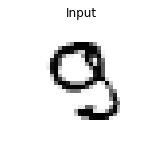

Final prediction: 9


Final prediction: 1


Final prediction: 6


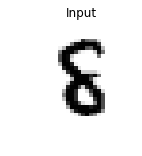

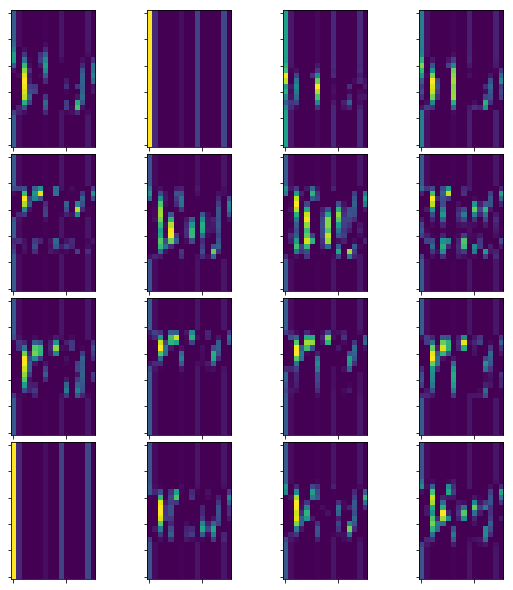

Final prediction: 8


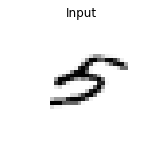

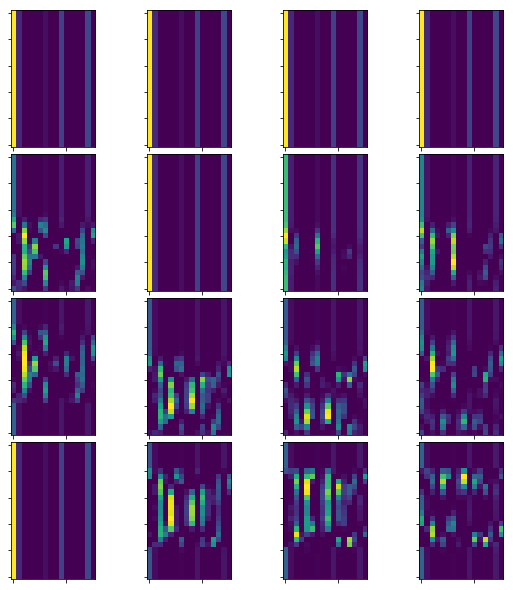

Final prediction: 5


In [16]:
np.random.seed(1337)
show_which_ones = np.random.randint(0, 999, 5)
for samp in show_which_ones:
    ShowInputImage(X_test[samp])
    ShowConvolutionOutput(X_test, samp)
    ShowFinalOutput(X_test, samp)

***
***
***

# Tensorflow

## Devise

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

### Load data

In [2]:
# mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
# mnist = input_data.read_data_sets('MNIST_data/', one_hot=True)
mnist = input_data.read_data_sets('/tmp/mnist/input_data', one_hot=True)
mnist = input_data.read_data_sets('/tmp/mnist/input_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/mnist/input_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/mnist/input_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/input_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting /tmp/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/input_data/t10k-labels-idx1-ubyte.gz


### Define parameters

In [3]:
# Training-related hyper-parameters
LEARNING_RATE = 0.001
MAX_TRAIN_EPOCHS = 1000
BATCH_SIZE = 128
display_step = 10

# Network parameters
INPUT_DIM = 784 # MNIST data input (img shape: 28x28)
NUM_CLASSES = 10 # MINST total classes (0-9 digits)
DROPOUT_KEEP_RATE = 0.75 # Dropout keep rate

### Define tensorflow graph

In [4]:
x = tf.placeholder(tf.float32, [None, INPUT_DIM])
y = tf.placeholder(tf.float32, [None, NUM_CLASSES])
keep_prob = tf.placeholder(tf.float32) # Dropout keep rate

In [5]:
def ConvTwoD(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

In [6]:
def MaxpoolTwoD(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

### Create CNN model

In [7]:
def ConvNet(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])
    
    # Convolution Layer
    conv1 = ConvTwoD(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = MaxpoolTwoD(conv1, k=2)
    
    # Convolution Layer
    conv2 = ConvTwoD(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = MaxpoolTwoD(conv2, k=2)
    
    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

### Dictionaries to store layers weight & bias

In [8]:
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected 7x7x64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7*7*64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, NUM_CLASSES]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([NUM_CLASSES]))
}

### Construct model

In [9]:
pred = ConvNet(x, weights, biases, keep_prob)

# Define loss and optimizer
print('oringinal y')
print(y)

print('ext_y')
ext_y = tf.reshape(y, [-1, 1, NUM_CLASSES])
ext_y = tf.tile(ext_y, [1, NUM_CLASSES, 1])
print(ext_y)

print('original pred')
print(pred)

print('ext_pred')
ext_pred = tf.reshape(pred, [-1, 1, NUM_CLASSES])
ext_pred = tf.tile(ext_pred, [1, NUM_CLASSES, 1])
print(ext_pred)

print('other_class')
other_class = tf.eye(NUM_CLASSES)
other_class = tf.reshape(other_class, [-1, NUM_CLASSES, NUM_CLASSES])
other_class = tf.tile(other_class, [BATCH_SIZE, 1, 1])
print(other_class)

print('tmp_sum')
tmp_sum = tf.reduce_sum((ext_y - other_class) * ext_pred, axis=2)
print(tmp_sum)

print('max_margin_loss')
max_margin_loss = tf.maximum(0.0, 0.1 - tmp_sum)
max_margin_loss = tf.reduce_sum(max_margin_loss)
print(max_margin_loss)

cost = max_margin_loss

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

oringinal y
Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)
ext_y
Tensor("Tile:0", shape=(?, 10, 10), dtype=float32)
original pred
Tensor("Add_1:0", shape=(?, 10), dtype=float32)
ext_pred
Tensor("Tile_1:0", shape=(?, 10, 10), dtype=float32)
other_class
Tensor("Tile_2:0", shape=(128, 10, 10), dtype=float32)
tmp_sum
Tensor("Sum:0", shape=(128, 10), dtype=float32)
max_margin_loss
Tensor("Sum_1:0", shape=(), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Launch the graph

In [10]:
with tf.Session() as sess:
    sess.run(init)
    step = 1
    
    # Keep training until reach max iterations
    while step < MAX_TRAIN_EPOCHS:
        batch_x, batch_y = mnist.train.next_batch(BATCH_SIZE)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT_KEEP_RATE})
    
        if step % display_step == 0:
            # Evaluate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict = {x: batch_x, y: batch_y, keep_prob: 1.})
            print('Iter ' + str(step) + \
                  ', Minibatch Loss = {:.6f}'.format(loss) + \
                  ', Training Accuracy = {:.5f}'.format(acc))
        step += 1
    print('Optimization Done.')
    
    # Calculate accuracy for 256 mnist test images
    print('Testing Accuracy:', \
          sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                        y: mnist.test.labels[:256],
                                        keep_prob: 1.}))

Iter 10, Minibatch Loss = 29916.226562, Training Accuracy = 0.25781
Iter 20, Minibatch Loss = 11221.146484, Training Accuracy = 0.46094
Iter 30, Minibatch Loss = 7735.000000, Training Accuracy = 0.60938
Iter 40, Minibatch Loss = 4943.526367, Training Accuracy = 0.71875
Iter 50, Minibatch Loss = 4739.937500, Training Accuracy = 0.73438
Iter 60, Minibatch Loss = 4080.156006, Training Accuracy = 0.78125
Iter 70, Minibatch Loss = 2637.435547, Training Accuracy = 0.82031
Iter 80, Minibatch Loss = 2813.341797, Training Accuracy = 0.82812
Iter 90, Minibatch Loss = 2181.476562, Training Accuracy = 0.83594
Iter 100, Minibatch Loss = 2034.104736, Training Accuracy = 0.86719
Iter 110, Minibatch Loss = 1344.939941, Training Accuracy = 0.88281
Iter 120, Minibatch Loss = 982.189758, Training Accuracy = 0.93750
Iter 130, Minibatch Loss = 2520.479492, Training Accuracy = 0.86719
Iter 140, Minibatch Loss = 2134.170898, Training Accuracy = 0.88281
Iter 150, Minibatch Loss = 1732.290527, Training Accurac

***
***
***

# TensorFlow

## Linear regression

先定義畫圖的程式

In [11]:
from IPython.display import clear_output, display, HTML, Image

In [12]:
def strip_consts(graph_def, max_const_size=32):
    '''
    Strip large constant values from graph_def
    '''
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add()
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = '<stripped %d bytes>' % size
    return strip_def

In [13]:
def show_graph(graph_def, max_const_size=32):
    '''
    Visualize tensorflow graph
    '''
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
#     strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = '''
        <script>
            function load() {{
                document.getElementById("{id}").pbtxt = {data};
            }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
            <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    '''.format(data=repr(str(strip_def)), id='graph' + str(np.random.rand()))
    
    iframe = '''
        <iframe seamless style="width:800px;height:400px;border:0" srcdoc="{}"></iframe>
    '''.format(code.replace('"', '&quot;'))
    
    display(HTML(iframe))

####

In [14]:
import tensorflow as tf
import numpy as np
from sklearn.datasets import fetch_california_housing

print(tf.__version__)

housing = fetch_california_housing()
m, n = housing.data.shape
print('Shape of dataset: ', m, ', ', n)

housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]
new_m, new_n = housing_data_plus_bias.shape
print('Shape of new dataset: ', new_m, ', ', new_n)

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name='x_const')
print(X)
X_trans = tf.transpose(X)
print(X)

y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32)

# Implement W = (X^T X)^{-1}X^T y
# \hat{y} = Xw --> learning y
w = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(X_trans, X)), X_trans), y)

with tf.Session() as sess:
    X_val = X.eval()
    print(X_val[0:2,:])
    
    W_print = w.eval()
    print(W_print)
    
    show_graph(tf.get_default_graph().as_graph_def())

1.12.0
Shape of dataset:  20640 ,  8
Shape of new dataset:  20640 ,  9
Tensor("x_const:0", shape=(20640, 9), dtype=float32)
Tensor("x_const:0", shape=(20640, 9), dtype=float32)
[[ 1.0000000e+00  8.3252001e+00  4.1000000e+01  6.9841270e+00
   1.0238096e+00  3.2200000e+02  2.5555556e+00  3.7880001e+01
  -1.2223000e+02]
 [ 1.0000000e+00  8.3014002e+00  2.1000000e+01  6.2381372e+00
   9.7188050e-01  2.4010000e+03  2.1098418e+00  3.7860001e+01
  -1.2222000e+02]]
[[-3.7383255e+01]
 [ 4.3574786e-01]
 [ 9.3480907e-03]
 [-1.0648697e-01]
 [ 6.4317447e-01]
 [-4.2286665e-06]
 [-3.7746700e-03]
 [-4.2583770e-01]
 [-4.3952349e-01]]


***
***
***

# TensorFlow

# Tensorboard

要跑這個似乎需要一個全新的 jupyter notebook session 不然會出錯，可能跟 tensorflow 的 session 有關，目前還不知道怎麼解決，只能 shutdown 後重開起來重跑

In [1]:
from __future__ import absolute_import, division, print_function

import os
import sys

import tensorflow as tf

from tensorflow.examples.tutorials.mnist import input_data

In [2]:
MAX_STEPS = 1000
LEARNING_RATE = 0.001
DROPOUT_KEEP_RATE = 0.9

DATA_DIR = '/tmp/mnist/input_data'
LOG_DIR = '/tmp/mnist/logs/mnist_with_summaries_4'

## Define functions

#### Random initiate network parameters

In [3]:
def weight_variable(shape):
    '''
    Create a weight variable with appropriate initialization
    '''
    initial = tf.truncated_normal(shape, stddev=0.1) # Constant Tensors
    return tf.Variable(initial)

In [4]:
def bias_variable(shape):
    '''
    Create a bias variable with appropriate initialization
    '''
    initial = tf.constant(0.1, shape=shape) # Constant Tensors
    return tf.Variable(initial)

####

In [5]:
def variable_summary(var):
    '''
    Attach a lot of summaries to a Tensor (for TensorBoard visualization).
    '''
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean) # summaries/mean
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

####

In [6]:
def add_nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    '''
    Reusable code for making a simple neural net layer.
    
    It does matrix multiply, bias add, and then use ReLU for non-linearity.
    It also setup name scoping so that the resultant graph is easy to read, and adds a number of summary ops
    '''
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This variable will hold the state of the weights for the layer.
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summary(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summary(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        return activations

####

In [7]:
def train():
    # Import data
    mnist = input_data.read_data_sets(DATA_DIR, one_hot=True)
    
    sess = tf.InteractiveSession()
    
    # Create a deep neural net model
    
    # Input placeholders
    with tf.name_scope('input'):
        x = tf.placeholder(tf.float32, [None, 784], name='x-input')
        y_ = tf.placeholder(tf.float32, [None, 10], name='y-input')
        
    with tf.name_scope('input_reshape'):
        image_shaped_input = tf.reshape(x, [-1, 28, 28, 1])
        tf.summary.image('input', image_shaped_input, 10)
        
    hidden_1 = add_nn_layer(x, 784, 500, 'layer1')
    
    with tf.name_scope('dropout'):
        keep_prob = tf.placeholder(tf.float32)
        tf.summary.scalar('dropout_keep_probability', keep_prob)
        dropped = tf.nn.dropout(hidden_1, keep_prob)
        
    # Do not apply softmax activation yet, just calculate logit for now.
    y = add_nn_layer(dropped, 500, 10, 'layer2', act=tf.identity)
    
    with tf.name_scope('cross_entropy'):
        diff = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y)
        with tf.name_scope('total'):
            cross_entropy = tf.reduce_mean(diff)
        tf.summary.scalar('cross_entropy', cross_entropy)
        
    with tf.name_scope('train'):
        train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(cross_entropy)
        
    with tf.name_scope('accuracy'):
        with tf.name_scope('correct_prediction'):
            correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
        with tf.name_scope('accuracy'):
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar('accuracy', accuracy)
        
    # Merge all the summary and write them out to /tmp/mnist/logs/mnist_with_summaries (by default)
    merged = tf.summary.merge_all()
    train_writer = tf.summary.FileWriter(LOG_DIR + '/train', sess.graph)
    test_writer = tf.summary.FileWriter(LOG_DIR + '/test')
    tf.global_variables_initializer().run()
    
    # Train the model and also write summaries
    # Every 10th step, measure test-set accuracy, and write test summaries
    # All other steps, run train_step on training data, & add training summaries
    
    def feed_dict(train):
        '''
        Make a TensorFlow feed_dict: maps data onto TensorFlow placeholders.
        '''
        if train:
            xs, ys = mnist.train.next_batch(100, fake_data=False)
            k = DROPOUT_KEEP_RATE
        else:
            xs, ys = mnist.test.images, mnist.test.labels
            k = 1.0
        return {x: xs, y_: ys, keep_prob: k}
    
    for i in range(MAX_STEPS):
        if i % 10 == 0: # Record summaries and test-set accuracy
            summary, acc = sess.run([merged, accuracy], feed_dict=feed_dict(False))
            test_writer.add_summary(summary, i)
            print('Accuracy at step %s: %s' % (i, acc))
        else: # Record train set summaries and train
            if i % 100 == 99: # Record execution stats
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
                summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True), options=run_options, run_metadata=run_metadata)
                train_writer.add_run_metadata(run_metadata, 'step%03d' % i)
                train_writer.add_summary(summary, i)
                print('Adding run metadata for ', i)
            else: # Record a summary
                summary, _ = sess.run([merged, train_step], feed_dict=feed_dict(True))
                train_writer.add_summary(summary, i)
    train_writer.close()
    test_writer.close()

In [8]:
train()

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/mnist/input_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/mnist/input_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/input_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Accuracy at step 0: 0.091
Accuracy at step 10: 0.7026
Accuracy at 

***
***
***

# Homework

## Reference

In [1]:
import numpy as np
import os
import tensorflow as tf

### Define function to make the output stable across runs

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
reset_graph()

In [4]:
from tensorflow.examples.tutorials.mnist import input_data

# mnist = input_data.read_data_sets('/tmp/data/')
mnist = input_data.read_data_sets('/tmp/mnist/input_data/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/mnist/input_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/input_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


#### Training on MNIST data but only on digits 0 to 4

In [5]:
X_train = mnist.train.images[mnist.train.labels < 5]
y_train = mnist.train.labels[mnist.train.labels < 5]

X_validation = mnist.validation.images[mnist.validation.labels < 5]
y_validation = mnist.validation.images[mnist.validation.labels < 5]

X_test = mnist.test.images[mnist.test.labels < 5]
y_test = mnist.test.images[mnist.test.labels < 5]

***
***
***

# Homework

## Solution

這裡也是需要一個全新的 notebook session 才能跑，不然會出問題

In [1]:
from __future__ import division, print_function, unicode_literals

import numpy as np
import os
import tensorflow as tf

### Define function to make the output stable across runs

In [2]:
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Define model

In [3]:
he_init = tf.contrib.layers.variance_scaling_initializer()

def dnn(inputs, n_hidden_layers=5, n_neurons=100, name=None, activation=tf.nn.elu, initializer=he_init):
    with tf.variable_scope(name, 'dnn'):
        for layer in range(n_hidden_layers):
            inputs = tf.layers.dense(inputs, n_neurons, activation=activation, kernel_initializer=initializer, name='hidden%d' % (layer + 1))
        return inputs

In [4]:
n_inputs = 28 * 28
n_outputs = 5

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int64, shape=(None), name='y')

dnn_outputs = dnn(X)

logits = tf.layers.dense(dnn_outputs, n_outputs, kernel_initializer=he_init, name='logits')
y_proba = tf.nn.softmax(logits, name='y_proba')

In [5]:
learning_rate = 0.1

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy, name='loss')

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss, name='training_op')

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')

init = tf.global_variables_initializer()
saver = tf.train.Saver()

### Load data

In [6]:
from tensorflow.examples.tutorials.mnist import input_data

# mnist = input_data.read_data_sets('/tmp/data/')
mnist = input_data.read_data_sets('/tmp/mnist/input_data/')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/mnist/input_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/input_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


#### Training on MNIST data but only on digits 0 to 4

In [7]:
X_train = mnist.train.images[mnist.train.labels < 5]
y_train = mnist.train.labels[mnist.train.labels < 5]

X_validation = mnist.validation.images[mnist.validation.labels < 5]
y_validation = mnist.validation.labels[mnist.validation.labels < 5]

X_test = mnist.test.images[mnist.test.labels < 5]
y_test = mnist.test.labels[mnist.test.labels < 5]

### Train model

In [8]:
n_epochs = 1000
batch_size = 20

max_checks_without_progress = 20
checks_without_progress = 0
best_loss = np.infty

with tf.Session() as sess:
    init.run()

    for epoch in range(n_epochs):
        rnd_idx = np.random.permutation(len(X_train))
        for rnd_indices in np.array_split(rnd_idx, len(X_train) // batch_size):
            X_batch, y_batch = X_train[rnd_indices], y_train[rnd_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
            
        loss_val, accuracy_val = sess.run([loss, accuracy], feed_dict={X: X_validation, y: y_validation})
        
        if loss_val < best_loss:
            save_path = saver.save(sess, './my_mnist_model_0_to_4.ckpt') # 檔名前面要有 ./ 不然會出問題
            best_loss = loss_val
            checks_without_progress = 0
        else:
            checks_without_progress += 1
            if checks_without_progress > max_checks_without_progress:
                print('Early stopping!')
                break
        print('{}\t Validation loss: {:.6f}\t Best loss: {:.6f}\t Accuracy: {:.2f}%'.format(epoch, loss_val, best_loss, accuracy_val * 100))

0	 Validation loss: 1.654406	 Best loss: 1.654406	 Accuracy: 20.91%
1	 Validation loss: 1.650659	 Best loss: 1.650659	 Accuracy: 18.73%
2	 Validation loss: 2.065296	 Best loss: 1.650659	 Accuracy: 22.01%
3	 Validation loss: 1.834414	 Best loss: 1.650659	 Accuracy: 22.01%
4	 Validation loss: 2.322108	 Best loss: 1.650659	 Accuracy: 22.01%
5	 Validation loss: 2.626658	 Best loss: 1.650659	 Accuracy: 22.01%
6	 Validation loss: 2.500185	 Best loss: 1.650659	 Accuracy: 22.01%
7	 Validation loss: 1.702504	 Best loss: 1.650659	 Accuracy: 19.27%
8	 Validation loss: 2.347390	 Best loss: 1.650659	 Accuracy: 20.91%
9	 Validation loss: 2.869021	 Best loss: 1.650659	 Accuracy: 22.01%
10	 Validation loss: 1.954960	 Best loss: 1.650659	 Accuracy: 22.01%
11	 Validation loss: 3.517900	 Best loss: 1.650659	 Accuracy: 19.08%
12	 Validation loss: 1.864432	 Best loss: 1.650659	 Accuracy: 20.91%
13	 Validation loss: 2.736669	 Best loss: 1.650659	 Accuracy: 18.73%
14	 Validation loss: 2.377687	 Best loss: 1.

In [9]:
with tf.Session() as sess:
    saver.restore(sess, './my_mnist_model_0_to_4.ckpt')
    acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
    print('Final test accuracy: {:.2f}%'.format(acc_test * 100))

INFO:tensorflow:Restoring parameters from ./my_mnist_model_0_to_4.ckpt
Final test accuracy: 19.07%
